In [ ]:
from IPython.display import display
from pathlib import Path
import json

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn

In [ ]:
# files
plot_dir = Path("plots")
if not plot_dir.exists():
    plot_dir.mkdir()

experiment1_f = Path("training_logs/deberta-v3-large/trainer_state.json")
experiment2_f = Path("training_logs/multimodel_finetuning_deberta-v3-base/checkpoint-10220/trainer_state.json")

experiment1_val_f = Path("results/deberta-v3-large/validation.csv")
experiment1_test_f = Path("results/deberta-v3-large/test.csv")
experiment2_test_f = Path("results/multimodel_finetuning_deberta-v3-base/test.csv")

baseline_val_f = Path("results/baseline/validation.csv")
baseline_test_f = Path("results/baseline/test.csv")

In [ ]:
# fileloader
baseline_val_df = pd.read_csv(baseline_val_f, index_col=0)
baseline_test_df = pd.read_csv(baseline_test_f, index_col=0)

experiment1_val_df = pd.read_csv(experiment1_val_f, index_col=0)
experiment1_test_df = pd.read_csv(experiment1_test_f, index_col=0)
experiment2_test_df = pd.read_csv(experiment2_test_f, index_col=0)

def load_experiment(experiment_file) -> pd.DataFrame:
    with open(experiment_file, "r") as file:
        experiment_df = pd.DataFrame(json.load(file)["log_history"]).set_index("epoch")
        # contains 2 entries per epoch
        extra_cols = ["grad_norm", "learning_rate", "loss", "step"]
        train_df = experiment_df[extra_cols].dropna()
        experiment_df = experiment_df[experiment_df["loss"].isna()].drop(["grad_norm", "learning_rate", "loss", "step"], axis=1)
        #experiment_df = pd.concat([train_df, experiment_df], axis=1)
        return experiment_df

experiment1_df = load_experiment(experiment1_f)
experiment2_df = load_experiment(experiment2_f)

In [ ]:
# display dataframes
display(experiment1_df)
display(baseline_val_df)
display(baseline_test_df)

In [ ]:
def format_df(metric: str, experiments: list[pd.DataFrame], experiment_names: list[str], prefixes: list[str] | str = "eval_") -> tuple[pd.DataFrame, str]:
    parsed_metric = metric.replace("_", " ").title()
    if isinstance(prefixes, list):
        for i, prefix, name, exp in zip(range(len(experiments)), prefixes, experiment_names, experiments):
            cur_metric = f"{prefix}{metric}"
            experiments[i] = exp.rename({cur_metric: parsed_metric}, axis=1)
            experiments[i]["Experiment"] = name.replace("_", " ").title()

    else:
        for i, name, exp in zip(range(len(experiments)), experiment_names, experiments):
            cur_metric = f"{prefixes}{metric}"
            experiments[i] = exp.rename({cur_metric: parsed_metric}, axis=1)
            experiments[i]["Experiment"] = name.replace("_", " ").title()
    
    formatted_df = pd.concat(experiments, axis=0)
    formatted_df.index.rename("Epoch", inplace=True)
    return formatted_df, parsed_metric

In [ ]:
# plot creation
matplotlib.rcParams['figure.dpi'] = 200

BASELINE_COLOR = "black"
CONTEXT = "poster"
FIGSIZE = (11, 7)

def plot_training_progress(metric: str, experiments: list[pd.DataFrame], experiment_names: list[str], prefixes: list[str] | str = "eval_", baseline: pd.DataFrame = None):
    formatted_df, metric_name = format_df(metric, experiments, experiment_names, prefixes)
    formatted_df = formatted_df[[metric_name, "Experiment"]]
    
    plt.figure(figsize=FIGSIZE)

    seaborn.lineplot(formatted_df, x=formatted_df.index, y=metric_name, hue="Experiment")

    handles, labels = plt.gca().get_legend_handles_labels()

    if not baseline is None:
        plt.hlines(baseline[f"validation_{metric}"].iloc[0], xmin=0, xmax=max(formatted_df.index), colors=[BASELINE_COLOR])
        patch = matplotlib.patches.Patch(color=BASELINE_COLOR, linewidth=1.0, label='Baseline')
        handles.append(patch) 
    
    plt.legend(handles=handles, title="Experiment")
    plt.ylim(0, 1)
    plt.title("Training Progress")
    seaborn.set_theme(context=CONTEXT, palette="pastel")
    seaborn.despine(top=True, left=True, bottom=True, right=True)
    seaborn.set_style("whitegrid", rc={"c": (0.95, 0.95, 0.95)})

    plt.show()

def plot_training_metrics(metrics: list[str], experiment: pd.DataFrame, experiment_name: str, prefix: str = "eval_"):
    formatted_df = pd.DataFrame(columns=["Value", "Metric"])
    for metric in metrics:
        df, metric_name = format_df(metric, [experiment], [metric], prefix)
        formatted_df = pd.concat([formatted_df, df.rename({metric_name: "Value", "Experiment": "Metric"}, axis=1)[["Value", "Metric"]]])
    formatted_df.index.rename("Epoch", inplace=True)

    plt.figure(figsize=FIGSIZE)

    seaborn.lineplot(formatted_df, x=formatted_df.index, y="Value", hue="Metric")
    
    plt.ylim(0, 1)
    plt.title(experiment_name)
    seaborn.set_theme(context=CONTEXT, palette="pastel")
    seaborn.despine(top=True, left=True, bottom=True, right=True)
    seaborn.set_style("whitegrid", rc={"c": (0.95, 0.95, 0.95)})

    plt.show()

def plot_result_metrics(metrics: list[str], experiments: list[pd.DataFrame], experiment_names: list[str], prefixes: list[str] | str = "eval_"):
    formatted_df = pd.DataFrame(columns=["Value", "Metric", "Experiment"])
    for metric in metrics:
        df, metric_name = format_df(metric, experiments, experiment_names, prefixes)
        df["Metric"] = metric_name
        formatted_df = pd.concat([formatted_df, df.rename({metric_name: "Value"}, axis=1)[["Value", "Metric", "Experiment"]]])

    plt.figure(figsize=FIGSIZE)

    graph = seaborn.catplot(formatted_df, x="Experiment", y="Value", col="Metric", hue="Experiment", kind="bar")

    graph.set_xticklabels(rotation=45)
    graph.set_titles("{col_name}")
    
    plt.ylim(0, 1)
    #plt.suptitle("Results")
    seaborn.set_theme(context=CONTEXT, palette="pastel")
    seaborn.despine(top=True, left=True, bottom=True, right=True)
    seaborn.set_style("whitegrid", rc={"c": (0.95, 0.95, 0.95)})

    plt.show()

def plot_result_metrics_single(categories: list[str], experiment: pd.DataFrame, experiment_name: str, prefix: str = "eval_", y_label: str = "Value"):
    y_label = y_label.title()
    formatted_df = pd.DataFrame(columns=[y_label, "Class", "Experiment"])
    for category in categories:
        df, metric_name = format_df(category, [experiment], [experiment_name], prefix)
        df["Class"] = metric_name
        formatted_df = pd.concat([formatted_df, df.rename({metric_name: y_label}, axis=1)[[y_label, "Class", "Experiment"]]])

    plt.figure(figsize=FIGSIZE)

    ax = seaborn.barplot(formatted_df, x="Class", y=y_label, hue="Class")

    plt.xticks(rotation=90)
    #graph.set_titles("{col_name}")
    
    plt.ylim(0, 1)
    #plt.suptitle("Results")
    seaborn.set_theme(context=CONTEXT, palette="pastel")
    seaborn.despine(top=True, left=True, bottom=True, right=True)
    seaborn.set_style("whitegrid", rc={"c": (0.95, 0.95, 0.95)})

    plt.show()

In [ ]:
exp1_name = "Deberta-v3-large"
exp2_name = "Multi-Binary-Deberta-v3-base"

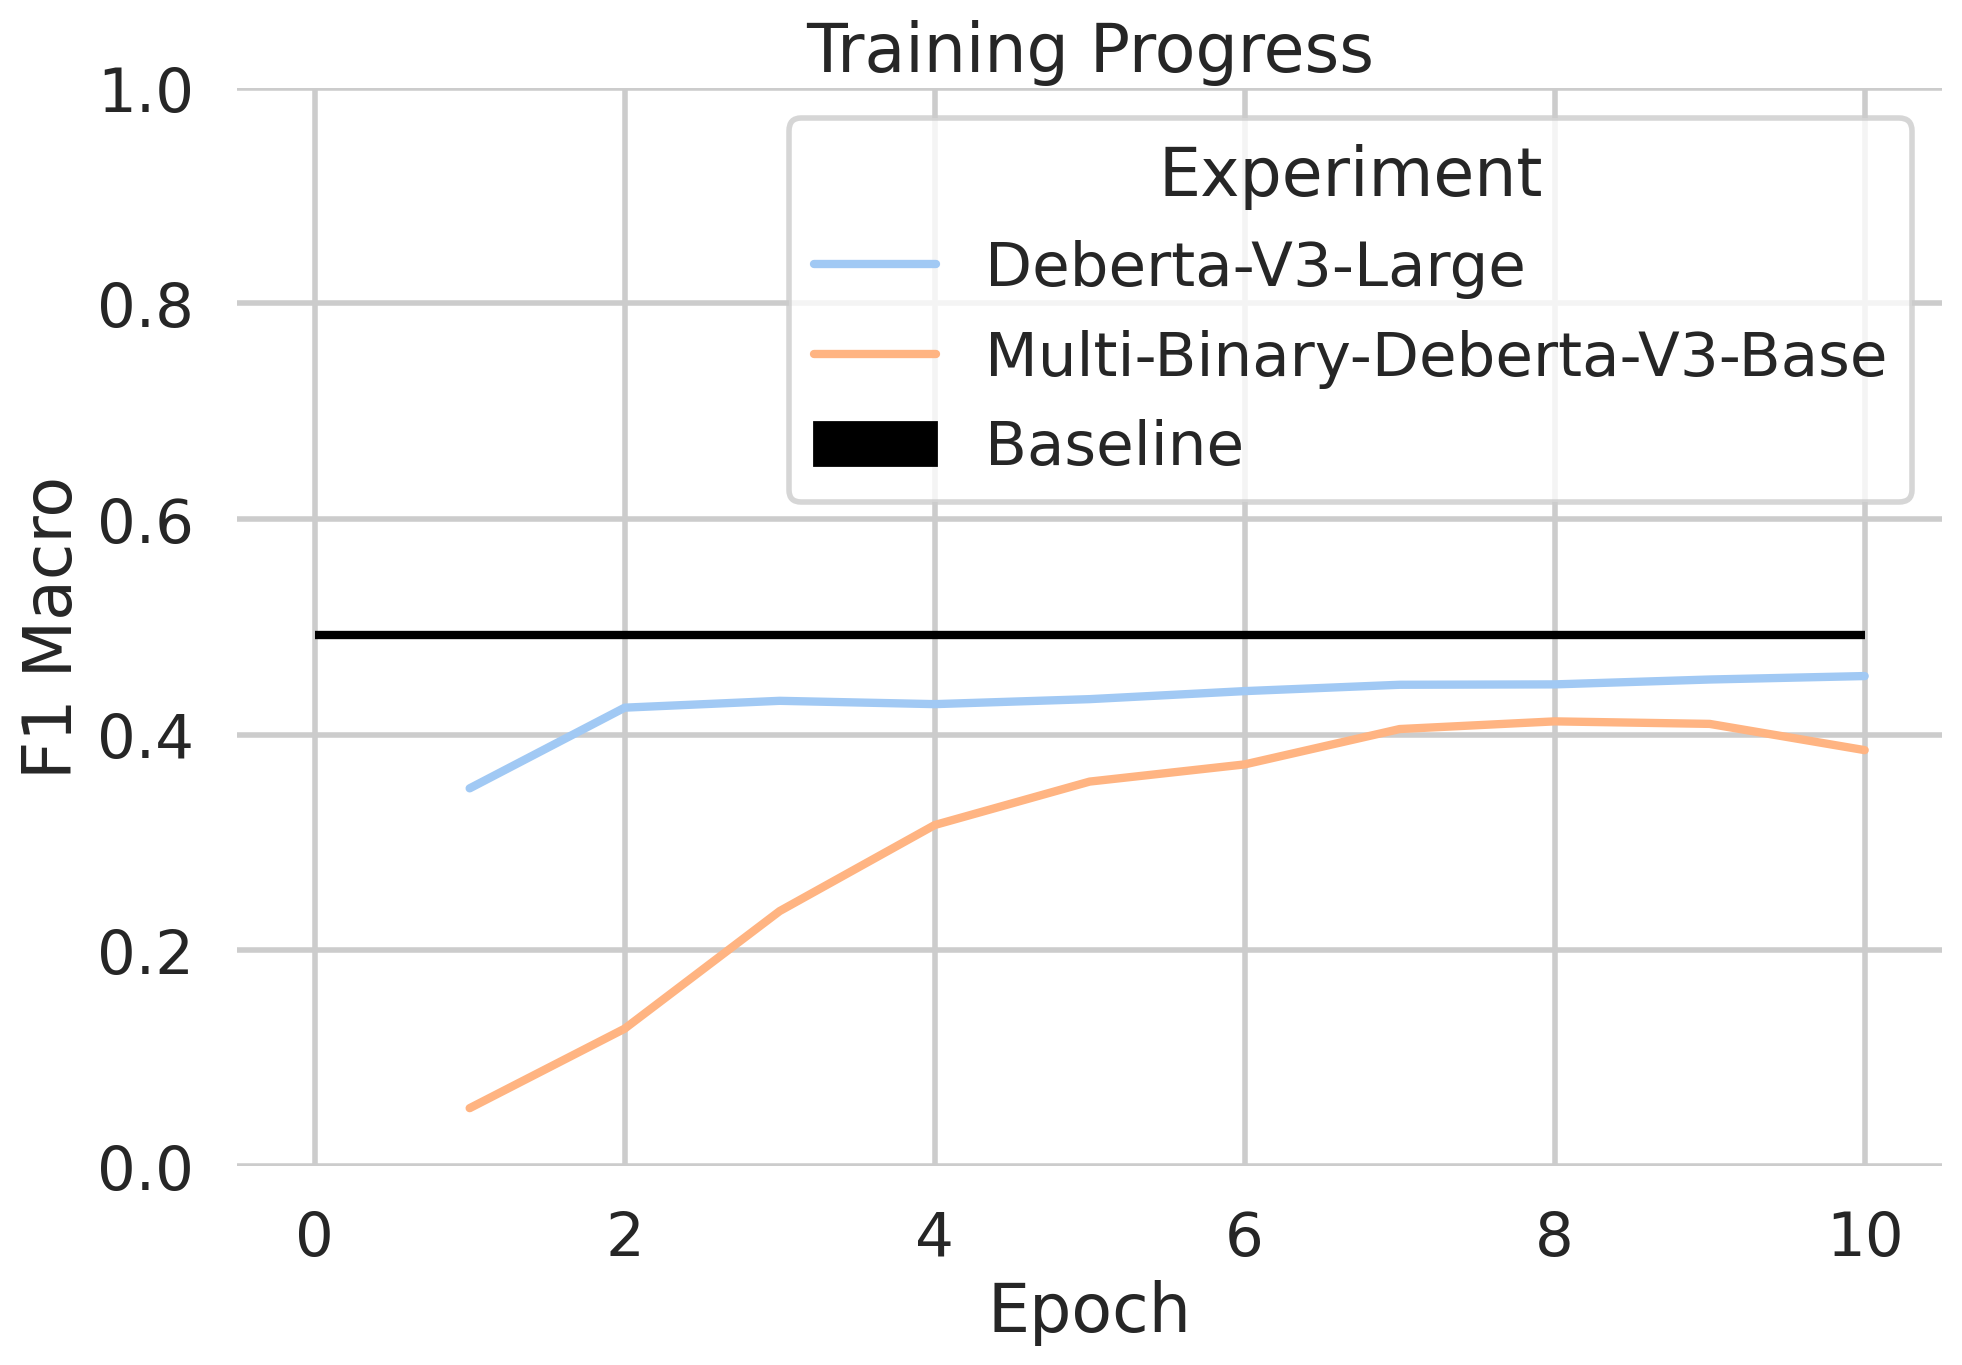

In [90]:
metric = "f1_macro"
experiment2_df = experiment2_df.iloc[:10]
experiments = [experiment1_df, experiment2_df]
experiment_names = [exp1_name, exp2_name]
prefixes = ["eval_", "eval_"]

plot_training_progress(metric, experiments, experiment_names, prefixes, baseline=baseline_val_df)

/tmp/ipykernel_268681/3777478236.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  formatted_df = pd.concat([formatted_df, df.rename({metric_name: "Value", "Experiment": "Metric"}, axis=1)[["Value", "Metric"]]])


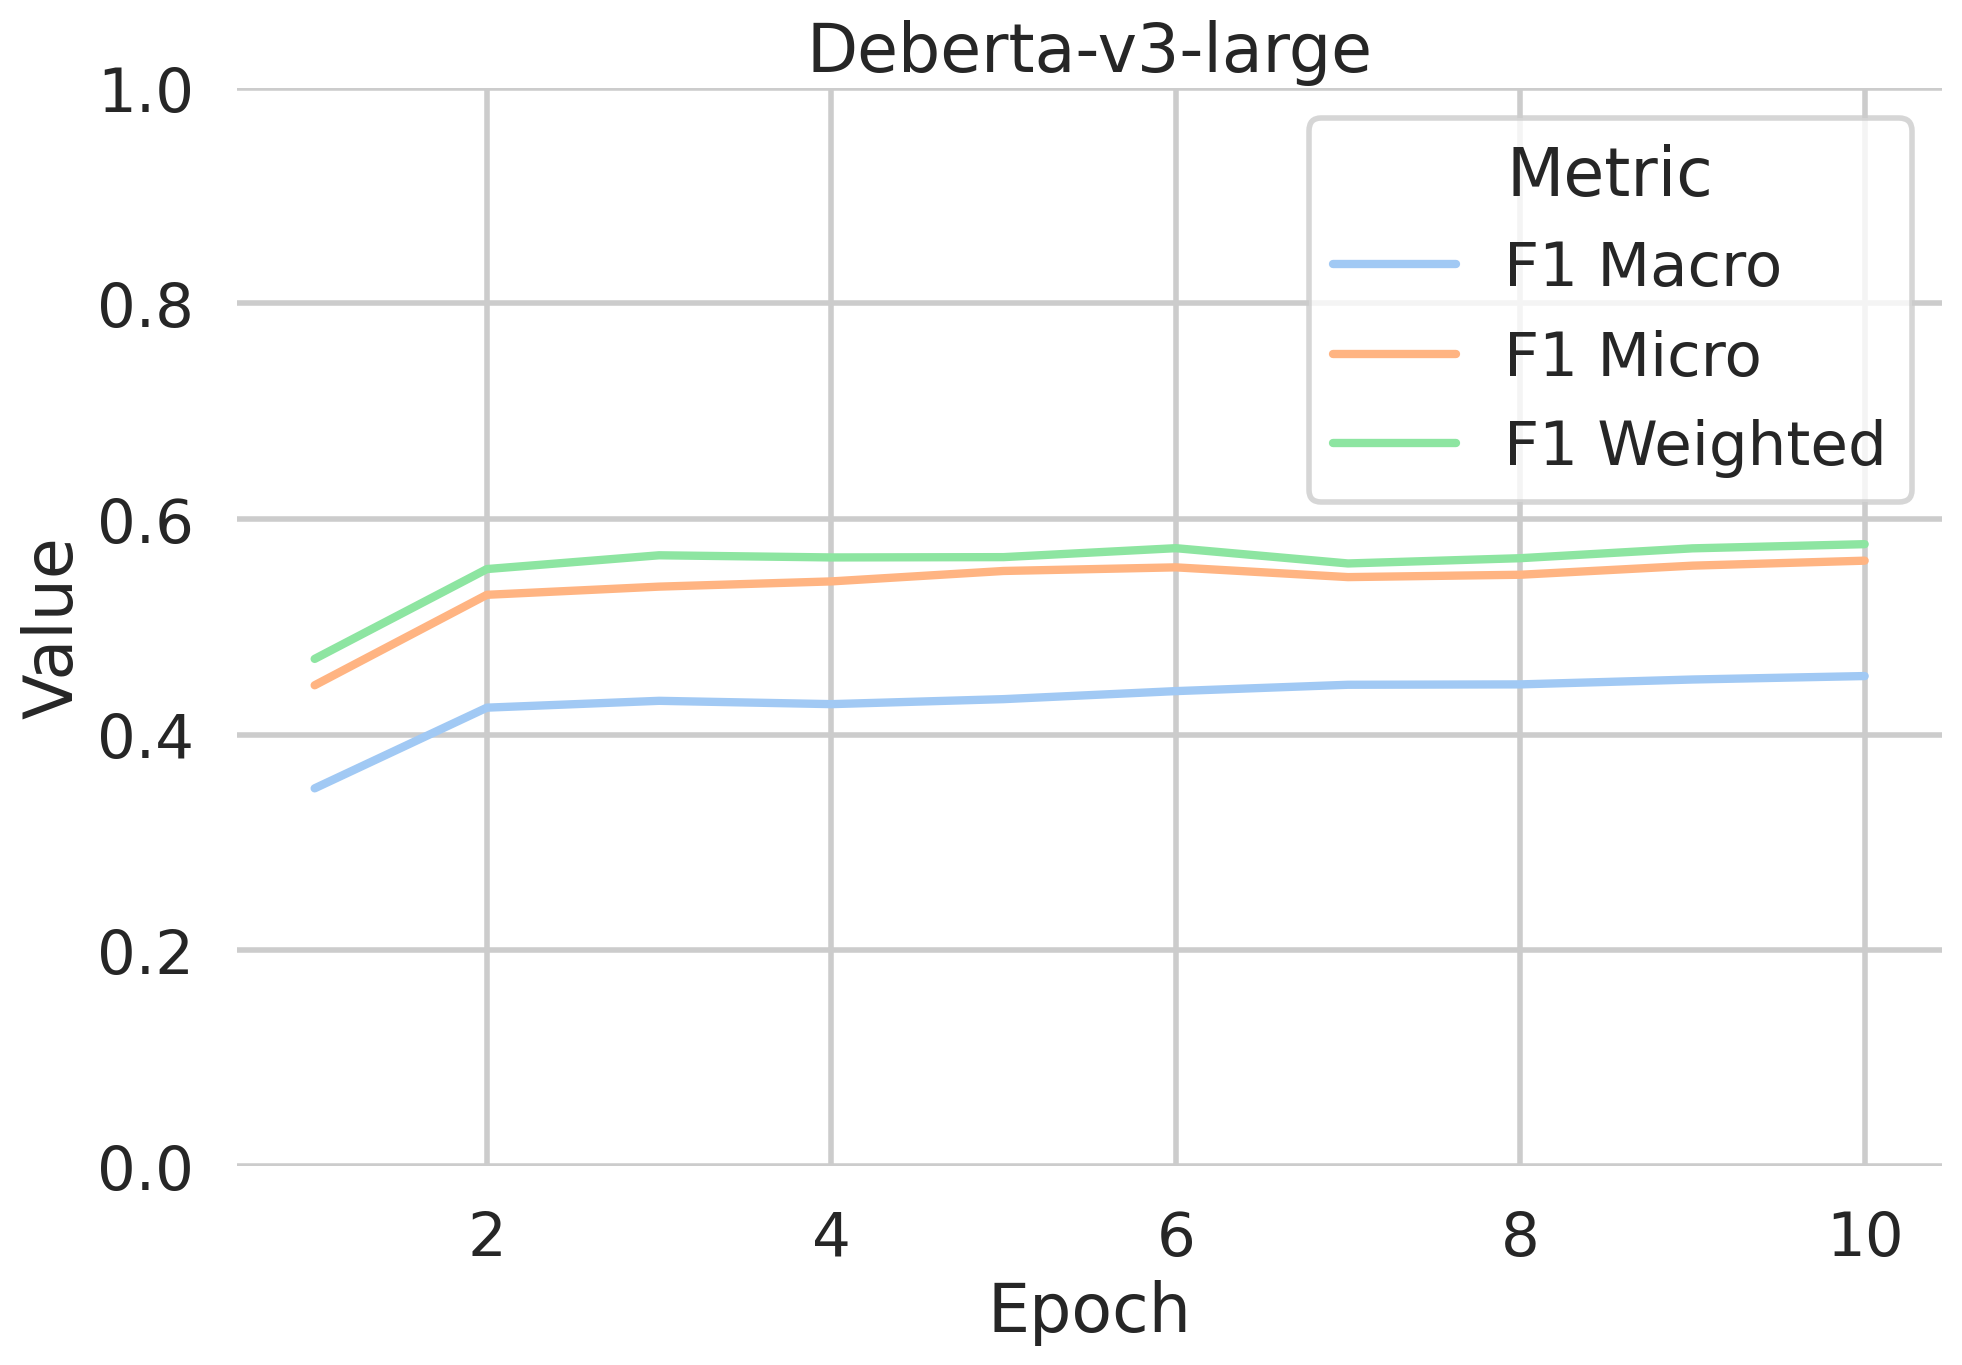

In [91]:
metrics = ["f1_macro", "f1_micro", "f1_weighted"]
experiment = experiment1_df
experiment_name = exp1_name
prefix = "eval_"

plot_training_metrics(metrics, experiment, experiment_name, prefix)

In [ ]:
metrics = ["f1_macro", "precision_macro", "recall_macro"]
experiment = experiment1_df
experiment_name = exp1_name
prefix = "eval_"

plot_training_metrics(metrics, experiment, experiment_name, prefix)

In [ ]:
metrics = ["f1_macro", "f1_micro", "f1_weighted"]
experiments = [experiment1_test_df, experiment1_val_df, baseline_test_df]
experiment_names = ["Deberta-v3-l Test", "Deberta-v3-l Val", "Baseline Test"]
prefixes = ["test_", "validation_", "test_"]

plot_result_metrics(metrics, experiments, experiment_names, prefixes)

/tmp/ipykernel_268681/3777478236.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  formatted_df = pd.concat([formatted_df, df.rename({metric_name: "Value"}, axis=1)[["Value", "Metric", "Experiment"]]])


<Figure size 2200x1400 with 0 Axes>

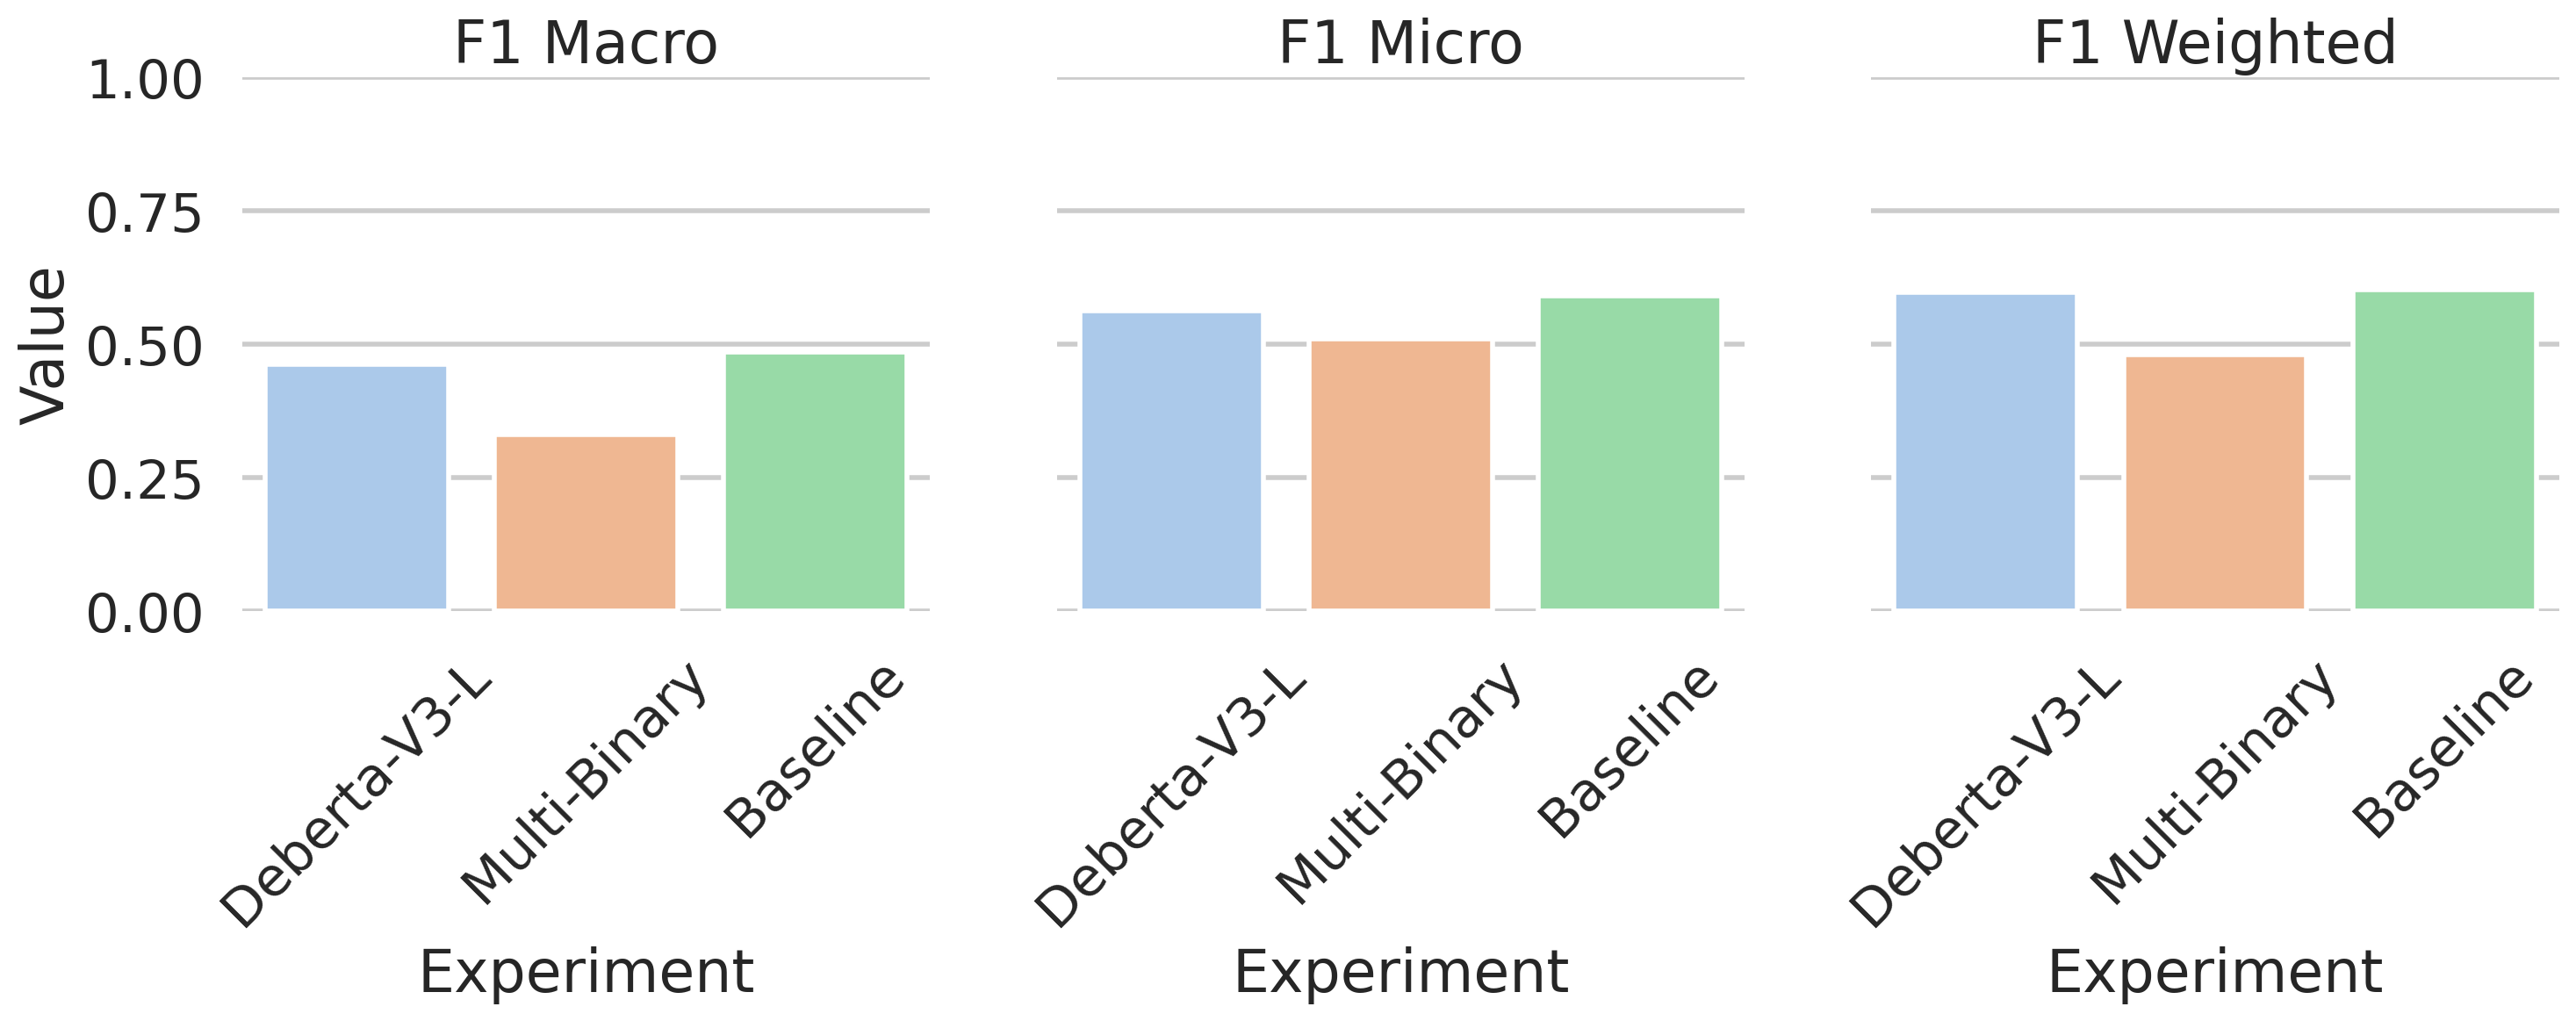

In [92]:
metrics = ["f1_macro", "f1_micro", "f1_weighted"]
experiments = [experiment1_test_df, experiment2_test_df, baseline_test_df]
experiment_names = ["Deberta-v3-l", "Multi-Binary", "Baseline"]
prefixes = ["test_", "test_", "test_"]

plot_result_metrics(metrics, experiments, experiment_names, prefixes)

/tmp/ipykernel_268681/3777478236.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  formatted_df = pd.concat([formatted_df, df.rename({metric_name: y_label}, axis=1)[[y_label, "Class", "Experiment"]]])


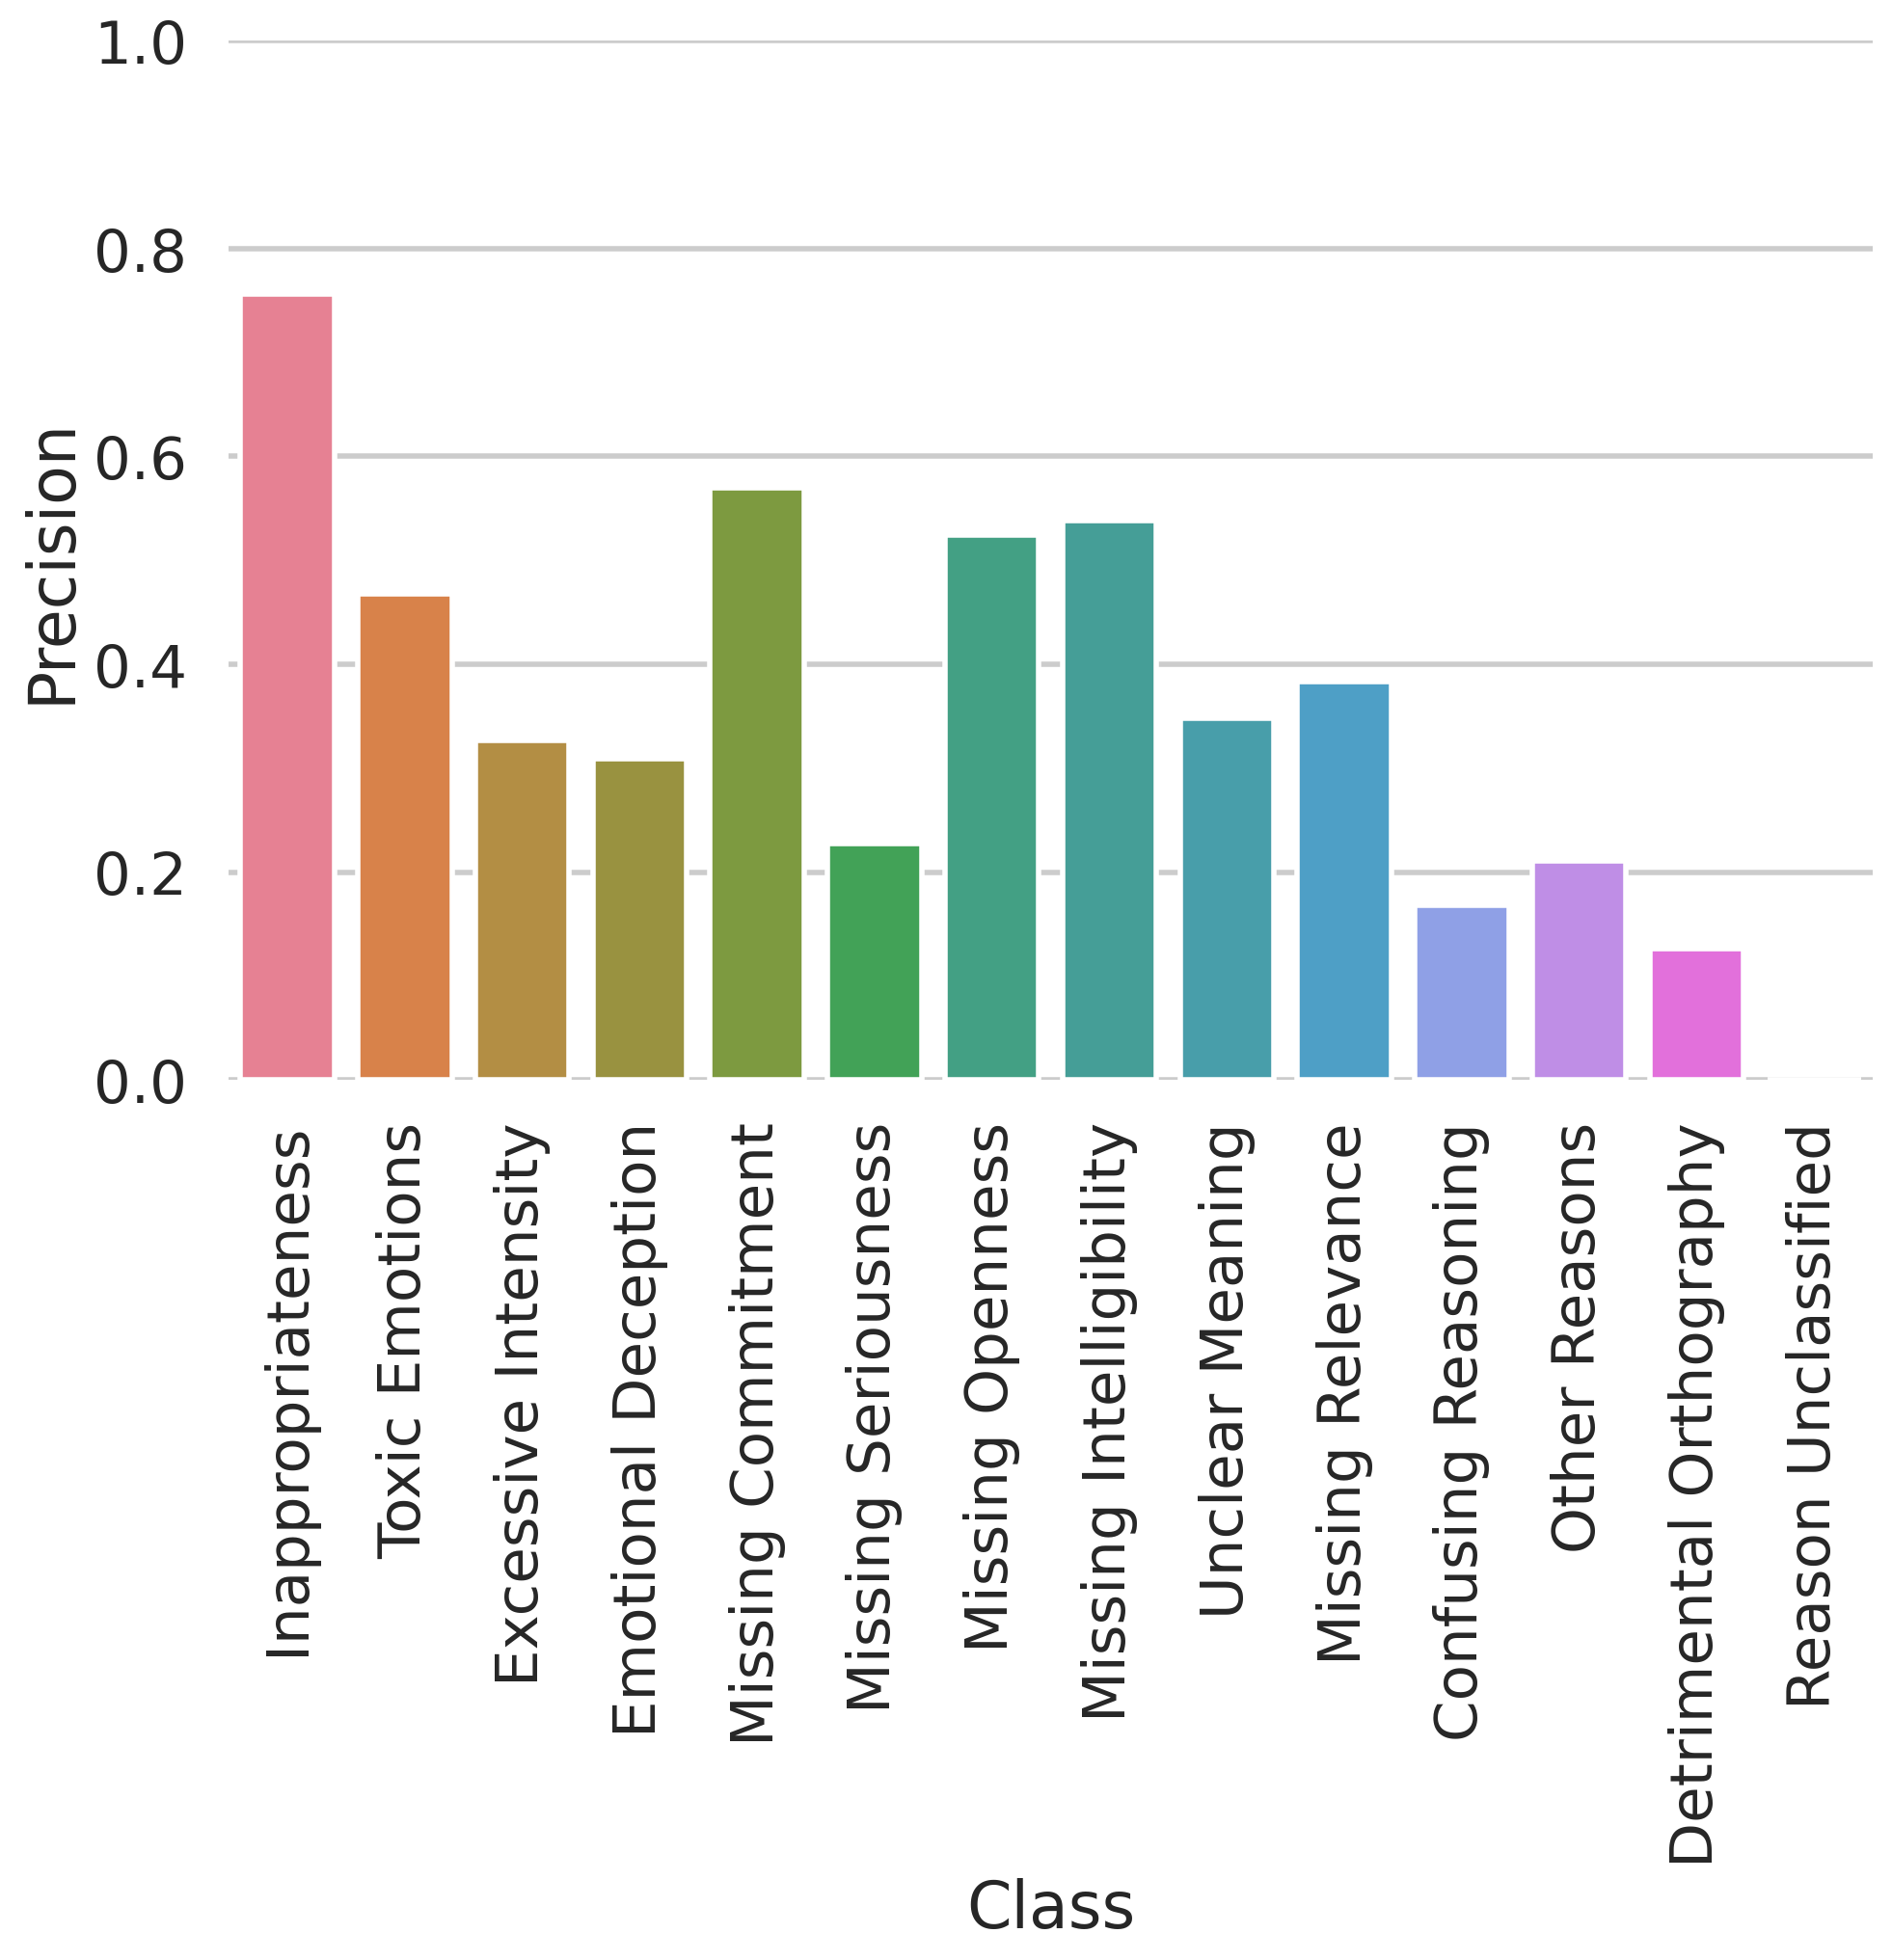

In [89]:
cls_metric = "precision"
classes = [ # class layer
    'Inappropriateness', # 0
    
    'Toxic Emotions', # 1
    'Excessive Intensity', # 2
    'Emotional Deception', # 2
    
    'Missing Commitment', # 1
    'Missing Seriousness', # 2
    'Missing Openness', # 2
    
    'Missing Intelligibility', # 1
    'Unclear Meaning', # 2
    'Missing Relevance', # 2
    'Confusing Reasoning', # 2
    
    'Other Reasons', # 1
    'Detrimental Orthography', # 2
    'Reason Unclassified', # 2
]
categories = [f"{class_}" for class_ in classes]
experiment = experiment1_test_df
experiment_name = "Deberta-v3-l Test"
prefix = f"test_{cls_metric}_"

plot_result_metrics_single(categories, experiment, experiment_name, prefix, cls_metric)